target_entropy = math.log(action_dim)

loss_alpha = -(alpha_log * (entropy - target_entropy)).mean()

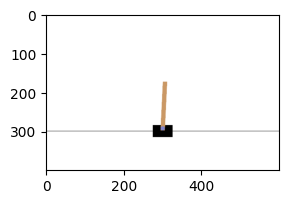

In [5]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [6]:
import torch

model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.5516, 0.4484],
        [0.5231, 0.4769]], grad_fn=<SoftmaxBackward0>)

In [7]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value1_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value2_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value1_next.load_state_dict(model_value1.state_dict())
model_value2_next.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[-0.2492,  0.0096],
        [-0.0720, -0.1909]], grad_fn=<AddmmBackward0>)

In [8]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        prob = model_action(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
        action = random.choices(range(2), weights=prob, k=1)[0]

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


11.0

In [9]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(self.pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_62452\3106662131.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(207,
 (array([ 0.04721738, -0.02451774,  0.01656285, -0.04620375], dtype=float32),
  0,
  1.0,
  array([ 0.04672703, -0.21987323,  0.01563878,  0.25165853], dtype=float32),
  False))

In [10]:
alpha_log = torch.nn.Parameter(torch.FloatTensor([-1.0]))

optimizer_alpha = torch.optim.Adam([alpha_log], lr=1e-4)
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=2e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=2e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=2e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_prob_entropy(state):
    prob = model_action(torch.FloatTensor(state).reshape(-1, 4))
    entropy = prob * (prob + 1e-8).log()
    entropy = -entropy.sum(dim=1, keepdim=True)

    return prob, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [11]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)
    requires_grad(model_action, False)
    alpha_log.requires_grad_(False)

    #计算target
    with torch.no_grad():
        #计算动作的熵
        prob, entropy = get_prob_entropy(next_state)
        target1 = model_value1_next(next_state)
        target2 = model_value2_next(next_state)
        target = torch.min(target1, target2)

    #加权熵,熵越大越好
    target = (prob * target).sum(dim=1, keepdim=True)
    target = target + alpha_log.exp() * entropy
    target = target * 0.98 * (1 - over) + reward

    #计算value
    value = model_value1(state).gather(dim=1, index=action)
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    value = model_value2(state).gather(dim=1, index=action)
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

1.396738886833191

In [12]:
def train_action(state):
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, True)
    alpha_log.requires_grad_(False)

    #计算熵
    prob, entropy = get_prob_entropy(state)

    #计算value
    value1 = model_value1(state)
    value2 = model_value2(state)
    value = torch.min(value1, value2)

    #求期望求和
    value = (prob * value).sum(dim=1, keepdim=True)

    #加权熵
    loss = -(value + alpha_log.exp() * entropy).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item(), entropy.detach()


_, entropy = train_action(state)

entropy.shape

torch.Size([64, 1])

In [13]:
def train_alpha(entropy):
    import math

    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, False)
    alpha_log.requires_grad_(True)

    target_entropy = math.log(2)
    loss_alpha = -(alpha_log * (entropy - target_entropy)).mean()

    optimizer_alpha.zero_grad()
    loss_alpha.backward()
    optimizer_alpha.step()

    return loss_alpha.item()


train_alpha(entropy)

-0.003297211602330208

In [14]:
def train():
    model_action.train()
    model_value1.train()
    model_value2.train()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(2000):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            _, entropy = train_action(state)
            soft_update(model_value1, model_value1_next)
            soft_update(model_value2, model_value2_next)
            train_alpha(entropy)

        if epoch % 10 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), alpha_log.exp().item(), test_result)


train()

0 419 0.2623108923435211 149.6
10 3379 0.03382936865091324 154.95
20 6120 0.004499976057559252 199.9
30 8630 0.0006091507384553552 185.55
40 11004 8.240409806603566e-05 153.75
50 13004 1.1149609235872049e-05 200.0
60 15004 1.5142057918637875e-06 200.0
70 17004 2.0575832593294763e-07 198.85
80 19372 2.7863016782703198e-08 200.0
90 20000 3.7736911373542625e-09 200.0
100 20000 5.1096399333872e-10 200.0
110 20000 6.932207585741423e-11 200.0
120 20000 9.39366553293075e-12 172.45
130 20000 1.2723180798854261e-12 200.0
140 20000 1.719673259044721e-13 200.0
150 20000 2.3275555677162822e-14 200.0
160 20000 3.1751578481660795e-15 200.0
170 20000 4.345655949076089e-16 200.0
180 20000 5.93948700863127e-17 200.0
190 20000 8.112802159462884e-18 200.0


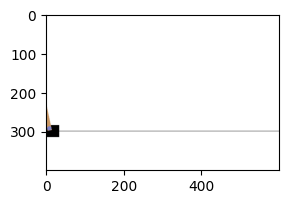

195.0

In [15]:
play(True)[-1]